## 프로젝트 : 폐렴 진단기 성능개선

### 목차
- Step 1. 실험환경 Set-up
- Step 2. 데이터 준비하기
- Step 3. 데이터 시각화
- Step 4. ResNet-18 구현
- Step 5. 데이터 imbalance 처리
- Step 6. 모델 훈련
- Step 7. 결과 확인과 시각화

### Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.



In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
from sklearn.model_selection import train_test_split
warnings.filterwarnings(action='ignore')
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 1
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.

의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.



In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state=8)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 폐 
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 비정상 폐
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1079
Pneumonia images count in training set: 3106


In [6]:
# tensorflow data API 활용하여, tf.data mini-batch
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [8]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2-1. augmentation 도입
데이터가 턱 없이 부족하기에 증강

In [12]:
# 랜덤하게 좌우 반전 함수
def augment_flip(image, label):
    image = tf.image.random_flip_left_right(image) # 50% 확률도 뒤집음
    return image, label

# 색상 대비 변경 함수
def augment_color_contrast(image, label):
    # Adjust color contrast using the contrast_factor
    augmented_image = tf.image.adjust_contrast(image, 1.5)
    return augmented_image, label

### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.

만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.



In [13]:
def show_image(imdage_data):
    image_batch, label_batch = next(iter(imdage_data))
    show_batch(image_batch.numpy(), label_batch.numpy())
    
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
def show_image(ds1, ds2, ds3):
    image_array = []
    label_array = []
    for image, label in ds1.take(4):  # Show 5 augmented images with flip
        image_array.append(image.numpy())
        label_array.append(label.numpy())
    for image, label in ds2.take(4):  # Show 5 augmented images with flip
        image_array.append(image.numpy())
        label_array.append(label.numpy())
    for image, label in ds3.take(4):  # Show 5 augmented images with flip
        image_array.append(image.numpy())
        label_array.append(label.numpy())
        
    for n in range(12):  # Display up to 4 images
        plt.figure(figsize=(5, 5))
        plt.subplot(3, 4, n+1)
        plt.imshow(image_array[n])
        if label_array[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")

    plt.tight_layout()
    plt.show()

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    orig_color_ds = ds
    aug_flip_color_ds = []
    aug_flip_ds = []
    conbined_ds = []

    
    # 전체 데이터 flip 
    aug_flip_ds = ds.map(
                        augment_flip,                 # 좌우반전
                        num_parallel_calls=2
                        )
  
    

    # 기존 데이터 색상 변경
    orig_color_ds = ds.map(
                        augment_color_contrast,       # 색상변경
                        num_parallel_calls=2
                    )
    # flip 데이터 색상 변경
    aug_flip_color_ds = orig_color_ds.map(
                        augment_color_contrast,       # 색상변경
                        num_parallel_calls=2
                    )
    #show_image(aug_flip_ds, orig_color_ds, aug_flip_color_ds)
    
    conbined_ds = ds.concatenate(orig_color_ds).concatenate(aug_flip_ds).concatenate(aug_flip_color_ds)
    #conbined_ds = ds.concatenate(aug_flip_ds) 
    conbined_ds = conbined_ds.shuffle(buffer_size=shuffle_buffer_size)
    conbined_ds = conbined_ds.repeat()
    conbined_ds = conbined_ds.batch(BATCH_SIZE)
    conbined_ds = conbined_ds.prefetch(buffer_size=AUTOTUNE)

    return conbined_ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


In [15]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


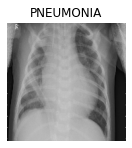

In [16]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.

Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다.

ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

#### Layer 구성
 - 3x3 CNN
 - BatchNormalization
 - 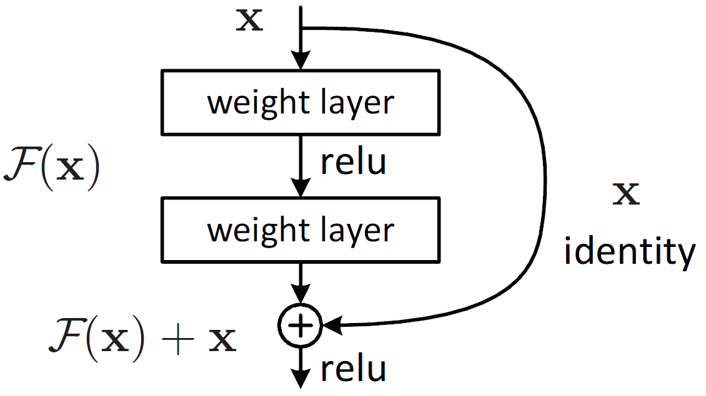
 
 위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요
 
 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)
 
 - 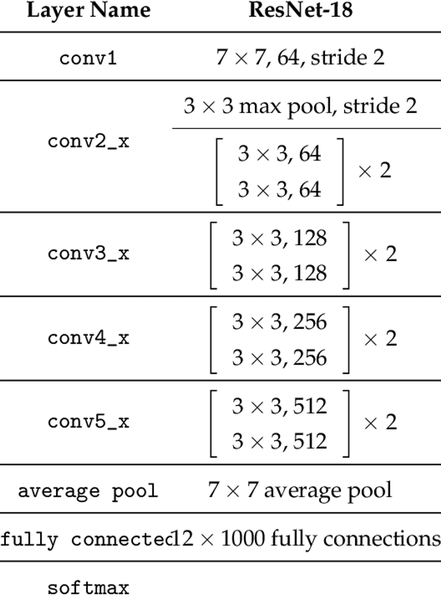

In [17]:
# def conv1(img_input) :
#     x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(img_input)
#     x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, name='conv1')(x)
#     x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv1_bn1')(x)
#     x = layers.ReLU(name='conv1_relu1')(x)
#     x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
#     x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)
#     return x  

def basic_block(inputs, filters, stride=1):
    expansion = 1
    shortcut = inputs
    
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or inputs.shape[-1] != filters * expansion:
        shortcut = tf.keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=stride, use_bias=False)(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x += shortcut
    x = tf.nn.relu(x)
    return x

In [18]:
# def conv2x(x, name="conv") :
#     orig = x;
    
#     x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=False, name='conv2')(x)
#     x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
#     x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv2_bn1')(x)
#     x = layers.ReLU(name='conv2_relu1')(x)
    
#     x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, use_bias=False, name='conv1')(x)
#     x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    
#     x = layers.Add(name=f'{name}.add')([orig, x])
#     x = layers.ReLU(name=f'{name}.relu2')(x)
    
#     return x
def resnet18(input_shape, num_classes=2):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = basic_block(x, 64, stride=1)
    x = basic_block(x, 64)

    x = basic_block(x, 128, stride=2)
    x = basic_block(x, 128)

    x = basic_block(x, 256, stride=2)
    x = basic_block(x, 256)

    x = basic_block(x, 512, stride=2)
    x = basic_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, x)
    return model

In [19]:
with tf.device('/GPU:0'):
    model = resnet18((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.

만약 이러한 처리를 생략한다면 어떻게 될까요?

또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))
print("class_weight", class_weight)

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67
class_weight {0: 1.9392956441149212, 1: 0.6736960721184804}


### Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

### Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다.

우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.

훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

In [21]:
with tf.device('/GPU:0'):
    model = resnet18((IMAGE_SIZE[0],IMAGE_SIZE[1],3), 1)
    model.summary()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 90, 90, 64)   9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 90, 90, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_17 (TFOpLambda)      (None, 90, 90, 64)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
4185/4185 [==============================] - 111s 23ms/step - loss: 0.3393 - accuracy: 0.7431 - precision: 0.7431 - recall: 1.0000 - val_loss: 0.3604 - val_accuracy: 0.7316 - val_precision: 0.7316 - val_recall: 1.0000
Epoch 2/10
4185/4185 [==============================] - 97s 23ms/step - loss: 0.1654 - accuracy: 0.7424 - precision: 0.7424 - recall: 1.0000 - val_loss: 0.1955 - val_accuracy: 0.7670 - val_precision: 0.7670 - val_recall: 1.0000
Epoch 3/10
4185/4185 [==============================] - 98s 23ms/step - loss: 0.1420 - accuracy: 0.7386 - precision: 0.7386 - recall: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.7517 - val_precision: 0.7517 - val_recall: 1.0000
Epoch 4/10
4185/4185 [==============================] - 97s 23ms/step - loss: 0.1054 - accuracy: 0.7446 - precision: 0.7446 - recall: 1.0000 - val_loss: 0.4220 - val_accuracy: 0.7459 - val_precision: 0.7459 - val_recall: 1.0000
Epoch 5/10
4185/4185 [==============================] - 97s 23ms/step - loss: 0.0898 - 

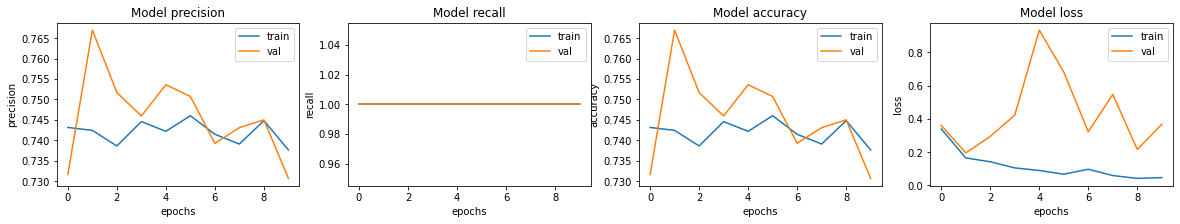

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

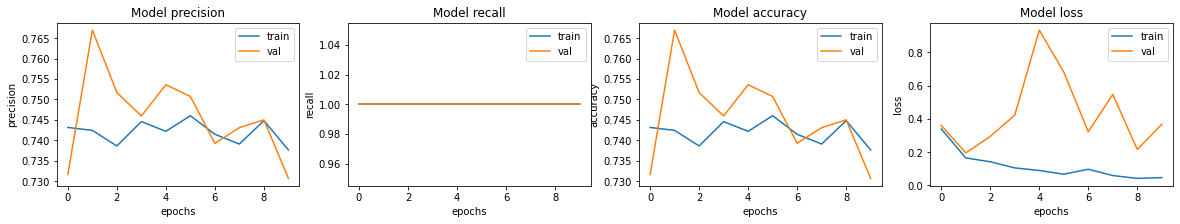

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

624/624 [==============================] - 7s 11ms/step - loss: 1.2786 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.2785505056381226,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
